In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime
import torchvision.models as models


In [2]:
# 画像のサイズ
IMG_SIZE = 224

# データのディレクトリのパス
FLOWER_DIR = '../input/flowers'

batch_size = 32

model_name = "EfficientNetb0"

In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
dataset = datasets.ImageFolder(FLOWER_DIR, transform=transforms)


In [5]:
# 学習データに使用する割合
n_train_ratio = 0.8

# 割合から個数を出す
n_train = int(len(dataset) * n_train_ratio)
n_val   = int(len(dataset) - n_train)


In [6]:
# 学習データと検証データに分割
train, val = random_split(dataset, [n_train, n_val])


In [7]:
# Data Loader
train_loader = DataLoader(train, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val, batch_size, num_workers=2)


In [8]:

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.efficientnet = models.efficientnet_b0(weights="IMAGENET1K_V1") 
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(in_features, num_classes)  # 新しい最終層を追加

    def forward(self, x):
        return self.efficientnet(x)


In [9]:
# 2. モデルの構築
model = CustomEfficientNet(num_classes=5).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/taisei/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 34.6MB/s]


In [10]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



In [11]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Training...'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Validation...'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [12]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.43it/s]


Epoch 1/50, Train Loss: 0.486872168344872, Val Loss: 0.3861766341659758, Train Acc: 0.8311613090066609, Val Acc: 0.875


Epoch 2/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.72it/s]


Epoch 2/50, Train Loss: 0.29715105598775027, Val Loss: 0.3231891942796884, Train Acc: 0.8963220388068346, Val Acc: 0.8981481481481481


Epoch 3/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.52it/s]


Epoch 3/50, Train Loss: 0.25172748413180634, Val Loss: 0.21957643495665657, Train Acc: 0.9081957717926441, Val Acc: 0.9398148148148148


Epoch 4/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.59it/s]


Epoch 4/50, Train Loss: 0.19419249876567693, Val Loss: 0.2383390430499006, Train Acc: 0.9264407761366927, Val Acc: 0.9131944444444444


Epoch 5/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.09it/s]


Epoch 5/50, Train Loss: 0.14978308287214173, Val Loss: 0.4358851942751143, Train Acc: 0.9417897480451781, Val Acc: 0.8703703703703703


Epoch 6/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.77it/s]


Epoch 6/50, Train Loss: 0.1526198379094843, Val Loss: 0.25675395914111976, Train Acc: 0.945264986967854, Val Acc: 0.9166666666666666


Epoch 7/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.10it/s]


Epoch 7/50, Train Loss: 0.11623252797697749, Val Loss: 0.28347083360508635, Train Acc: 0.9542426875181002, Val Acc: 0.9166666666666666


Epoch 8/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.83it/s]


Epoch 8/50, Train Loss: 0.10900631275410964, Val Loss: 0.2435035375809228, Train Acc: 0.9568491167101072, Val Acc: 0.9212962962962963


Epoch 9/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.40it/s]


Epoch 9/50, Train Loss: 0.08673516424507703, Val Loss: 0.37184685272061163, Train Acc: 0.9652476107732406, Val Acc: 0.9166666666666666


Epoch 10/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.60it/s]


Epoch 10/50, Train Loss: 0.12002018248122708, Val Loss: 0.2372320655181452, Train Acc: 0.9556907037358818, Val Acc: 0.9189814814814815


Epoch 11/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.56it/s]


Epoch 11/50, Train Loss: 0.10890484808848422, Val Loss: 0.2925769802596834, Train Acc: 0.9571387199536635, Val Acc: 0.9178240740740741


Epoch 12/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.36it/s]


Epoch 12/50, Train Loss: 0.0964395652185673, Val Loss: 0.21492481990544884, Train Acc: 0.9588763394150015, Val Acc: 0.9386574074074074


Epoch 13/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.79it/s]


Epoch 13/50, Train Loss: 0.05689696544535441, Val Loss: 0.36607229097366883, Train Acc: 0.9748045178105995, Val Acc: 0.9282407407407407


Epoch 14/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.22it/s]


Epoch 14/50, Train Loss: 0.09245374744592635, Val Loss: 0.23299616723562833, Train Acc: 0.9606139588763394, Val Acc: 0.9421296296296297


Epoch 15/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.31it/s]


Epoch 15/50, Train Loss: 0.07549321453443894, Val Loss: 0.24723633430484268, Train Acc: 0.965537214016797, Val Acc: 0.9351851851851852


Epoch 16/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.99it/s]


Epoch 16/50, Train Loss: 0.07357523198648591, Val Loss: 0.2843425986184566, Train Acc: 0.965537214016797, Val Acc: 0.9108796296296297


Epoch 17/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.88it/s]


Epoch 17/50, Train Loss: 0.05840094903240276, Val Loss: 0.28638673609950477, Train Acc: 0.9716188821314798, Val Acc: 0.9305555555555556


Epoch 18/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.10it/s]


Epoch 18/50, Train Loss: 0.057853045146836174, Val Loss: 0.2380435293264411, Train Acc: 0.9707500724008109, Val Acc: 0.9386574074074074


Epoch 19/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.27it/s]


Epoch 19/50, Train Loss: 0.04726269098529679, Val Loss: 0.21125197189825554, Train Acc: 0.9785693599768317, Val Acc: 0.9409722222222222


Epoch 20/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.91it/s]


Epoch 20/50, Train Loss: 0.05736293292617443, Val Loss: 0.3287689085635874, Train Acc: 0.9742253113234868, Val Acc: 0.9247685185185185


Epoch 21/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.19it/s]


Epoch 21/50, Train Loss: 0.07849424566081334, Val Loss: 0.2061164534340302, Train Acc: 0.9684332464523603, Val Acc: 0.9398148148148148


Epoch 22/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.26it/s]


Epoch 22/50, Train Loss: 0.08909669978692084, Val Loss: 0.32040997097889584, Train Acc: 0.9661164205039097, Val Acc: 0.9131944444444444


Epoch 23/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.20it/s]


Epoch 23/50, Train Loss: 0.06401908405943313, Val Loss: 0.25357486086863057, Train Acc: 0.9710396756443672, Val Acc: 0.9317129629629629


Epoch 24/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.10it/s]


Epoch 24/50, Train Loss: 0.06252407231060766, Val Loss: 0.30049265845230333, Train Acc: 0.9721980886185926, Val Acc: 0.9328703703703703


Epoch 25/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.31it/s]


Epoch 25/50, Train Loss: 0.051538171442486694, Val Loss: 0.22554241277760378, Train Acc: 0.9753837242977121, Val Acc: 0.9421296296296297


Epoch 26/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.23it/s]


Epoch 26/50, Train Loss: 0.07236442030962364, Val Loss: 0.18335679514954487, Train Acc: 0.9678540399652477, Val Acc: 0.9479166666666666


Epoch 27/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.41it/s]


Epoch 27/50, Train Loss: 0.032753259797632765, Val Loss: 0.2202218435532241, Train Acc: 0.9826238053866203, Val Acc: 0.9444444444444444


Epoch 28/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.04it/s]


Epoch 28/50, Train Loss: 0.02492856832490973, Val Loss: 0.2752256683263652, Train Acc: 0.9846510280915146, Val Acc: 0.9328703703703703


Epoch 29/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.39it/s]


Epoch 29/50, Train Loss: 0.025614269713098162, Val Loss: 0.2942407851245392, Train Acc: 0.9855198378221836, Val Acc: 0.9293981481481481


Epoch 30/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.16it/s]


Epoch 30/50, Train Loss: 0.04376942195568373, Val Loss: 0.33301109156605824, Train Acc: 0.9782797567332754, Val Acc: 0.9201388888888888


Epoch 31/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.71it/s]


Epoch 31/50, Train Loss: 0.07261321526543002, Val Loss: 0.2881577195668662, Train Acc: 0.9701708659136983, Val Acc: 0.9131944444444444


Epoch 32/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.58it/s]


Epoch 32/50, Train Loss: 0.051634759316873675, Val Loss: 0.28842190494415937, Train Acc: 0.9739357080799305, Val Acc: 0.9166666666666666


Epoch 33/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.54it/s]


Epoch 33/50, Train Loss: 0.045480401245670425, Val Loss: 0.3007176327303535, Train Acc: 0.9765421372719374, Val Acc: 0.9270833333333334


Epoch 34/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.52it/s]


Epoch 34/50, Train Loss: 0.037971087585221844, Val Loss: 0.40875380024037977, Train Acc: 0.9794381697075007, Val Acc: 0.9108796296296297


Epoch 35/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 19.47it/s]


Epoch 35/50, Train Loss: 0.04767856058701612, Val Loss: 0.36086499670313466, Train Acc: 0.9768317405154938, Val Acc: 0.9270833333333334


Epoch 36/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 18.09it/s]


Epoch 36/50, Train Loss: 0.0407206968520768, Val Loss: 0.2594750895406361, Train Acc: 0.9794381697075007, Val Acc: 0.9363425925925926


Epoch 37/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 17.46it/s]


Epoch 37/50, Train Loss: 0.025638699995448475, Val Loss: 0.2680877318812741, Train Acc: 0.9852302345786272, Val Acc: 0.9386574074074074


Epoch 38/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 18.16it/s]


Epoch 38/50, Train Loss: 0.035404210130109616, Val Loss: 0.3871579711084013, Train Acc: 0.9788589632203881, Val Acc: 0.9236111111111112


Epoch 39/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 17.83it/s]


Epoch 39/50, Train Loss: 0.06164389930866228, Val Loss: 0.3235278310323203, Train Acc: 0.9742253113234868, Val Acc: 0.9224537037037037


Epoch 40/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 17.68it/s]


Epoch 40/50, Train Loss: 0.06657417045068975, Val Loss: 0.27269808754876806, Train Acc: 0.9687228496959166, Val Acc: 0.9317129629629629


Epoch 41/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 18.16it/s]


Epoch 41/50, Train Loss: 0.031281051669317675, Val Loss: 0.39630451522491594, Train Acc: 0.9808861859252823, Val Acc: 0.9166666666666666


Epoch 42/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 17.77it/s]


Epoch 42/50, Train Loss: 0.04969802744119215, Val Loss: 0.29920248807994304, Train Acc: 0.9765421372719374, Val Acc: 0.9224537037037037


Epoch 43/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 17.96it/s]


Epoch 43/50, Train Loss: 0.040805377342893794, Val Loss: 0.2709454410123052, Train Acc: 0.9785693599768317, Val Acc: 0.9375


Epoch 44/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.73it/s]


Epoch 44/50, Train Loss: 0.06012878635659962, Val Loss: 0.23843878811156308, Train Acc: 0.9759629307848248, Val Acc: 0.9259259259259259


Epoch 45/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.68it/s]


Epoch 45/50, Train Loss: 0.02550034818086375, Val Loss: 0.31872817106475987, Train Acc: 0.9834926151172894, Val Acc: 0.9351851851851852


Epoch 46/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 18.47it/s]


Epoch 46/50, Train Loss: 0.043567032309408976, Val Loss: 0.2985998141510343, Train Acc: 0.9777005502461628, Val Acc: 0.9247685185185185


Epoch 47/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 18.72it/s]


Epoch 47/50, Train Loss: 0.04380999639071089, Val Loss: 0.32937382134884874, Train Acc: 0.9797277729510571, Val Acc: 0.9340277777777778


Epoch 48/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.46it/s]


Epoch 48/50, Train Loss: 0.019993724903525897, Val Loss: 0.31952629378065467, Train Acc: 0.9846510280915146, Val Acc: 0.9317129629629629


Epoch 49/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.34it/s]


Epoch 49/50, Train Loss: 0.01673442002662749, Val Loss: 0.30892283672949783, Train Acc: 0.9837822183608457, Val Acc: 0.9409722222222222


Epoch 50/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 18.10it/s]

Epoch 50/50, Train Loss: 0.029333115301095492, Val Loss: 0.3524164554697496, Train Acc: 0.980596582681726, Val Acc: 0.9189814814814815


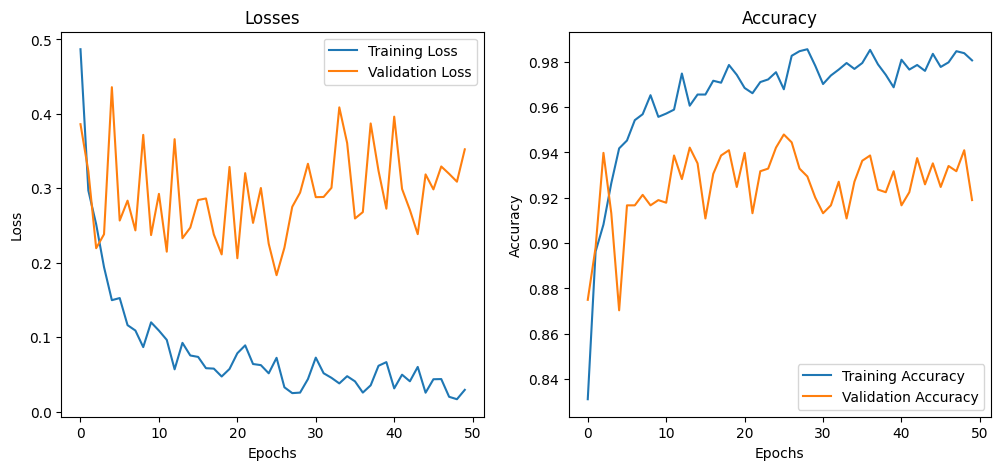

In [ ]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'{model_name}_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'{model_name}_{timestamp}.png'))

# 画像を表示
plt.show()
